## Accessing dataset from Google Drive

In [1]:
import json
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
with open('/content/drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
classes = list(cat_to_name.values())
print(classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cat_to_name.json  flower_data  model_cifar.pt  PyTorchLab.ipynb  style-transfer
['fire lily', 'canterbury bells', 'bolero deep blue', 'pink primrose', 'mexican aster', 'prince of wales feathers', 'moon orchid', 'globe-flower', 'grape hyacinth', 'corn poppy', 'toad lily', 'siam tulip', 'red ginger', 'spring crocus', 'alpine sea holly', 'garden phlox', 'globe thistle', 'tiger lily', 'ball moss', 'love in the mist', 'monkshood', 'blackberry lily', 'spear thistle', 'balloon flower', 'blanket flower', 'king protea', 'oxeye daisy', 'yellow iris', 'cautleya spicata', 'carnation', 'silverbush', 'bearded iris', 'black-eyed susan', 'windflower', 'japanese anemone', 'giant white arum lily', 'great masterwort', 'sweet pea', 'tree mallow', 'trumpet creeper', 'daffodil', 'pincushion flower', 'hard-leaved pocket orchid', 'sunflower', 'osteospermum', 'tree poppy', 'desert-ro

## Installing PyTorch and Pillow


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' #'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Platform:', platform, 'Accelerator:', accelerator)
!pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
!pip install Pillow==4.0.0

Platform: cp36-cp36m Accelerator: cu80
tcmalloc: large alloc 1073750016 bytes == 0x5c4dc000 @  0x7f8f8eb082a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
google-colab 0.0.1a1 has requirement six~=1.11.0, but you'll have six 1.12.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
Torch 0.4.0 CUDA 8.0.61
Device: cuda:0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-

In [3]:
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline
%reload_ext autoreload
%autoreload

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
data_dir = '/content/drive/My Drive/Colab Notebooks/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.25),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.4065), (0.229, 0.224, 0.225))
    ])

valid_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ])

train_set = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_set = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_set  = datasets.ImageFolder(test_dir, transform=test_transforms)

train_dataloaders = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=0)
valid_dataloaders = torch.utils.data.DataLoader(valid_set, batch_size=20, shuffle=True, num_workers=0)
test_dataloaders  = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=True, num_workers=0)

dataiter = iter(train_dataloaders)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()
print(images.shape)
print(labels.shape)


(20, 3, 224, 224)
(20,)


In [5]:
classifier = nn.Sequential(nn.Linear(25088, 1000),
                      nn.ReLU(),
                      torch.nn.Dropout(p=0.5),
                      nn.Linear(1000, 102))

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier = classifier
for param in vgg16.classifier.parameters():
    param.requires_grad = True

print(vgg16)
if train_on_gpu:
    vgg16.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(vgg16.classifier.parameters(), lr=0.005)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Showing 20 random images

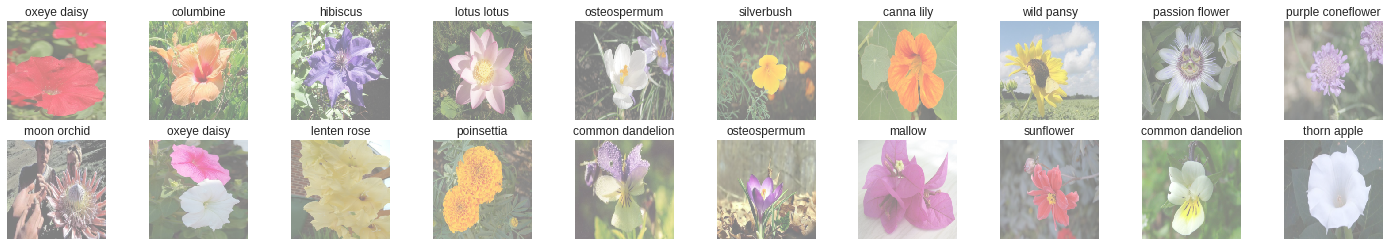

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(valid_dataloaders)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(0, 20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(cat_to_name[str(list(labels.numpy())[idx])])

## Training the model

In [7]:
n_epochs = 20
valid_loss_min = np.Inf
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    vgg16.train()
    for data, target in train_dataloaders:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step() 
        train_loss += loss.item()*data.size(0)
    vgg16.eval()
    for data, target in valid_dataloaders:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = vgg16(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)    
    train_loss = train_loss/len(train_dataloaders.dataset)
    valid_loss = valid_loss/len(valid_dataloaders.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(vgg16.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

KeyboardInterrupt: ignored

## Loading Best Model

In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/model_cifar.pt'))

## Testing

In [0]:
epochs = 2
steps = 0
print_every = 5
for epoch in range(epochs):
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            vgg16.eval()
            with torch.no_grad():
                for inputs, labels in test_dataloaders:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    logps = vgg16.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Test loss: {test_loss/len(test_dataloaders):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_dataloaders):.3f}")
            running_loss = 0